In [1]:
run ='sd'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','preprocessing')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)
from tools.NDinterp import NDinterp
from tools.log_progress import log_progress

T_mask_path = os.path.join(data_dir,'external','tamura','EASE_landmask_H.data')
T_lat_lon_path = os.path.join(data_dir,'external','tamura','latlon.data')
T_data_path = os.path.join(data_dir,'external','tamura')
era_path = os.path.join(data_dir,'external','era_interim','ERA_Interim_1992_2011.2daily.*winds.nc')
R_grid_path = os.path.join(data_dir,'processed',run+'_grd.nc')

In [2]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

In [3]:
#read in tamura land mask
with open(T_mask_path,'rb') as fid:
    T_mask = np.fromfile(fid,count=(721*721),dtype='float32').reshape((721,721))
    T_mask = np.flipud(T_mask)

In [4]:
#get tamura lat lon coordinates
with open(T_lat_lon_path,'rb') as fid:
    T_lat_lon = np.fromfile(fid,count=(721*721*2),dtype='float32').reshape((2,721,721))
T_lat,T_lon = (T_lat_lon[0],T_lat_lon[1])
T_lat = np.flipud(T_lat)
T_lon = np.flipud(T_lon)
T_lon[T_lon<0]+=360

In [5]:
#read in era interim winds and resample from twice daily to daily
era_ds = xr.open_mfdataset(era_path,data_vars='minimal').sel(time='2007',latitude=slice(-30,-90)).resample(time='D').mean()

#get era coordinates
era_lon,era_lat = era_ds.longitude.values,era_ds.latitude.values
era_lon_2d,era_lat_2d = np.meshgrid(era_lon,era_lat)

In [6]:
#define regridding functions for era and tamura data
# griddata takes flat arrays of source points and data and interpolates to 2d grid
        

def regrid_tamura(slon,slat,sdat,tlon,tlat):
    
    slon = slon[slat<(tlat.max()+2)] # only load data up to 2 deg further north of roms highest latitude
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]
    
    #tamura comes from npstereo curvilinear grid
    #we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
    # otherwise we get an interpolation gap between 0/360
    
    ii1 = (slon<2.0)

    slon_ext1 = slon[ii1]
    slon_ext1[slon_ext1<=1]+=360

    ii2 = (slon>358.0)

    slon_ext2 = slon[ii2]
    slon_ext2[slon_ext2>=359]-=360
    
    slon_ext = np.hstack((slon_ext1,slon_ext2))
    slat_ext = np.hstack((slat[ii1],slat[ii2]))
    sdat_ext = np.hstack((sdat[ii1],sdat[ii2]))
      
    slon = np.hstack((slon,slon_ext))
    slat = np.hstack((slat,slat_ext))
    sdat = np.hstack((sdat,sdat_ext))

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
    
    return tdat

In [7]:
# era is more easy, since its on a mercator projection
# we just have to extend the arrays at the beginning and end to bridge the gap at 0/360

def regrid_era(slon_raw,slat,sdat_raw,tlon,tlat):
    
    slon = np.zeros(np.size(slon_raw)+2)
    slon[0] = slon_raw[-1]-360
    slon[1:-1] = slon_raw[:]
    slon[-1] = slon_raw[0]+360

    slon, slat = np.meshgrid(slon,slat)
    
    sdat = np.zeros((np.size(sdat_raw,0),np.size(sdat_raw,1)+2))
    sdat[:,0] = sdat_raw[:,-1]
    sdat[:,1:-1] = sdat_raw[:,:]
    sdat[:,-1] = sdat_raw[:,0]
    
    slon = slon[slat<(tlat.max()+2)]
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat

In [8]:
# MAKE THE MAGIC HAPPEN FOR 2007 AND save in interim folder
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [1]

dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    #open Tamura month flux data 
    T_month_path = os.path.join(T_data_path,'TSDM2hb_2007_'+month+'.data')
    with open(T_month_path,'rb') as fid:
        T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        
        #read in Tamura heat and fresh water flux and turn in right position
        shflux_tmp = np.flipud(T_data[0,Tidx])
        ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        #fill in tamuar mask for later resampling
        shflux_tmp[T_mask==0] = np.nan
        shflux_tmp = NDinterp(shflux_tmp)
        
        ssflux_tmp[T_mask==0] = np.nan
        ssflux_tmp = NDinterp(ssflux_tmp)
        
        shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        
        shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4

        ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        del ssflux_tmp
        
        #select era-interim winds
        uwnd = era_ds.u10[Eidx].values
        vwnd = era_ds.v10[Eidx].values
        
        #rotate wind directions to roms grid
        uv = (uwnd+1j*vwnd)*np.exp(1j*-(era_lon_2d/180*np.pi))
        uwnd = uv.real
        vwnd = uv.imag
        
        
        uwnd = regrid_era(era_lon,era_lat,uwnd,R_ulon,R_ulat)
        vwnd = regrid_era(era_lon,era_lat,vwnd,R_vlon,R_vlat)
        
        
        #convert to stress
        signu = np.sign(uwnd)
        signv = np.sign(vwnd)

        rhoAir = 1.3
        Cd = 1.4e-3

        taux = rhoAir*Cd*np.square(uwnd)*signu
        tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uwnd, vwnd
        
        ds.sustr[Tidx]= taux#taux_smooth*fac
        ds.svstr[Tidx]= tauy#tauy_smooth*fac
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'tamura_file':T_data_path,
                          'era-interim file':era_path,
                          'grid file':R_grid_path,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        int_path = os.path.join(data_dir,'interim',run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+int_path)
        ds[var].to_netcdf(int_path,'w',unlimited_dims=dim)
    #del ds
    
    #update the day of the year value for next month
    dayOfYear += days

Processing month:  jan with days:  31
Containing days of year:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


Saving month to ../../data/preprocessing/interim/sd_shflux_01.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_01.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_01.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_01.nc
Processing month:  feb with days:  28
Containing days of year:  [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59]


Saving month to ../../data/preprocessing/interim/sd_shflux_02.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_02.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_02.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_02.nc
Processing month:  mar with days:  31
Containing days of year:  [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90]


Saving month to ../../data/preprocessing/interim/sd_shflux_03.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_03.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_03.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_03.nc
Processing month:  apr with days:  30
Containing days of year:  [ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120]


Saving month to ../../data/preprocessing/interim/sd_shflux_04.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_04.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_04.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_04.nc
Processing month:  may with days:  31
Containing days of year:  [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151]


Saving month to ../../data/preprocessing/interim/sd_shflux_05.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_05.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_05.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_05.nc
Processing month:  jun with days:  30
Containing days of year:  [152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181]


Saving month to ../../data/preprocessing/interim/sd_shflux_06.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_06.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_06.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_06.nc
Processing month:  jul with days:  31
Containing days of year:  [182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212]


Saving month to ../../data/preprocessing/interim/sd_shflux_07.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_07.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_07.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_07.nc
Processing month:  aug with days:  31
Containing days of year:  [213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243]


Saving month to ../../data/preprocessing/interim/sd_shflux_08.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_08.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_08.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_08.nc
Processing month:  sep with days:  30
Containing days of year:  [244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273]


Saving month to ../../data/preprocessing/interim/sd_shflux_09.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_09.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_09.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_09.nc
Processing month:  oct with days:  31
Containing days of year:  [274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304]


Saving month to ../../data/preprocessing/interim/sd_shflux_10.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_10.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_10.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_10.nc
Processing month:  nov with days:  30
Containing days of year:  [305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334]


Saving month to ../../data/preprocessing/interim/sd_shflux_11.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_11.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_11.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_11.nc
Processing month:  dec with days:  31
Containing days of year:  [335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365]


Saving month to ../../data/preprocessing/interim/sd_shflux_12.nc
Saving month to ../../data/preprocessing/interim/sd_swflux_12.nc
Saving month to ../../data/preprocessing/interim/sd_sustr_12.nc
Saving month to ../../data/preprocessing/interim/sd_svstr_12.nc


In [9]:
#collect all interim results, merge to yearly data amd adjust cycle length attribute
#save forcing files in processed folder
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(data_dir,'interim',run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(data_dir,'processed',run+'_'+var+'.nc')
    print('saving final to'+out_path)
    ds.to_netcdf(out_path,'w')

saving final to../../data/preprocessing/processed/sd_shflux.nc
saving final to../../data/preprocessing/processed/sd_swflux.nc
saving final to../../data/preprocessing/processed/sd_sustr.nc
saving final to../../data/preprocessing/processed/sd_svstr.nc


# below just devel stuff

AttributeError: 'Dataset' object has no attribute 'sustr'

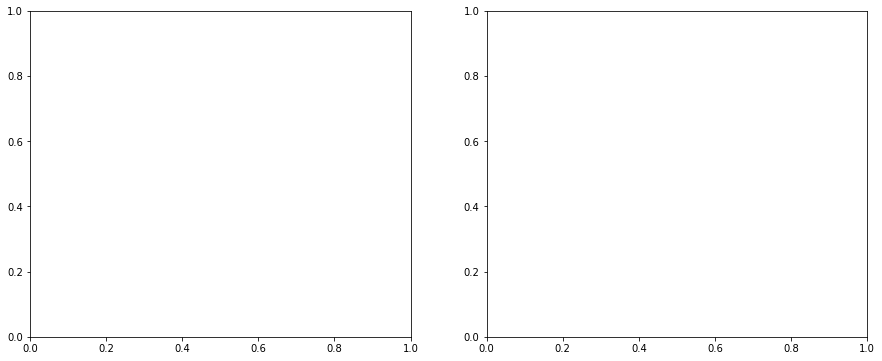

In [10]:
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.sustr.plot(ax=ax0,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
old.sustr[0].plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [ ]:
%matplotlib notebook
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.shflux.plot(ax=ax0)
old_shflx.shflux[0].plot(ax=ax1)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [ ]:
path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_sustr.nc')
old_sustr = xr.open_dataset(path)

path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_shflux.nc')
old_shflx = xr.open_dataset(path)